In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import datetime as dt
import yfinance as yf
import scipy as sp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use("ggplot")

In [2]:
TRADING_DAYS = 251

In [3]:
def get_data_from_yf(stocks, start_date: dt.date, end_date: dt.date, dropna=True) -> pd.DataFrame:
    # dropna decides if you want to drop all NaN values
    stock_data = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)["Close"]

    return pd.DataFrame(stock_data).dropna() if dropna else pd.DataFrame(stock_data)

If there is a law in finance, that would be "level of price doesn't matter, only return matters" (I think it's from Paul Wilmott). It's weird the things (prices) we are modeling never show up in the equations.

# <font face="gotham" color="purple"> Simple vs Log Returns</font>

We have discussed the merits of log returns in time series session, it is time to revisit the topic before we dive into quantitative financial topics.

## <font face="gotham" color="purple"> Simple Multi-Period Return</font>

For compound return we have following formula
$$
S_T=S_0\left[1+\frac{r}{T}\right]^{Tt}
$$
where $S_0$ is initial investment,$t$ is the total duration (usually in years), $r$ is annual return, $T$ is number of compound periods (days, weeks, or seasons). If we break the compound period into infinitely small chunks, we receive continuous compound formula
$$
\lim _{T \rightarrow \infty} S_T=S_0 e^{rt}
$$

Sometimes we just omitted $t$ if we are modeling one year duration.

And this plot shows that as the number of compound periods increase, discrete compounding converges to continous 

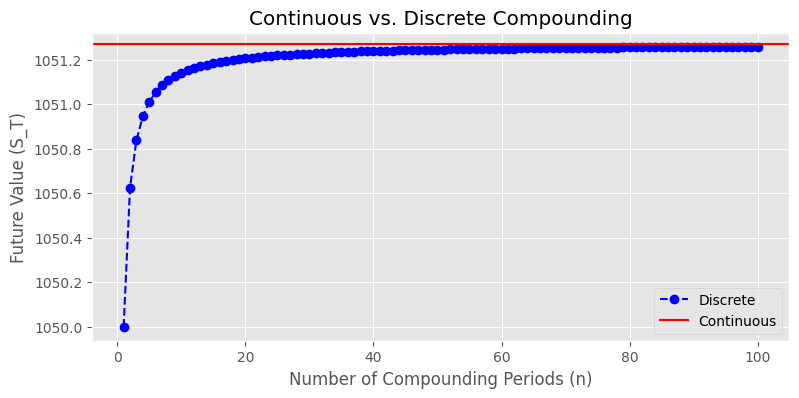

In [4]:
S_0 = 1000
r = 0.05
t = 1 

S_T_continuous = S_0 * np.exp(r * t)

compound_periods = range(1, 101)  
S_T_discrete = [S_0 * (1 + r / n) ** (n * t) for n in compound_periods]

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(compound_periods, S_T_discrete, label="Discrete", linestyle='--', marker='o', color='blue')
ax.axhline(y=S_T_continuous, color='r', linestyle='-', label="Continuous")
ax.set_xlabel("Number of Compounding Periods (n)")
ax.set_ylabel("Future Value (S_T)")
ax.legend()
plt.title("Continuous vs. Discrete Compounding")
plt.show()


## <font face="gotham" color="purple"> Simple Returns Simulation</font>

Add a random component into simple return at period $t$

$$\begin{aligned} r_t= & \frac{S_t-S_{t-1}}{S_{t-1}} \\ & =\frac{r}{T}+\frac{\sigma}{\sqrt{T}} \varepsilon_t \quad \varepsilon_t \sim N(0,1)\end{aligned}$$

the $\sqrt{T}$ comes from the properties of standard deviation. 

In [5]:
def simple_return_simulation(
        s0: float=100, 
        r: float=0.1, 
        vol: float=0.10, 
        trading_days: int=TRADING_DAYS, 
        paths: int=100,
    ) -> None:    
    norm_draws = [[np.random.randn() for i in range(trading_days)] for i in range(paths)]


    # Daily gross returns, note that we've added 1 to each return
    gross_returns =[[1 + r / trading_days + vol / (np.sqrt(trading_days)) * i for i in draw_pod] for draw_pod in norm_draws]

    # insert 1 at the begining for every normal random sequence
    # this is for accumulative calculation
    gross_return = [np.insert(returns, 0, 1) for returns in gross_returns]

    # simple return is multiplicative
    cumulative_returns = [np.cumprod(returns) for returns in gross_return]


    fig, ax = plt.subplots(figsize=(14, 7))

    for path in cumulative_returns:
        ax.plot(list(range(0, trading_days + 1)), path, linewidth=0.7)

    ax.set_title("Simple Return Simulation in One Year", fontsize=20)
    ax.set_xlabel("Trading Days", fontsize=16)
    ax.set_ylabel("Simple Returns", fontsize=16)

    ax_hist = ax.twinx()
    ax_hist.set_yticks([])
    ax_hist.hist([path[-1] for path in cumulative_returns], bins=100, orientation='horizontal', alpha=0.6, color='grey')
    ax_hist.set_ylabel('Frequency', fontsize=16)
    plt.show()

In [6]:
# load a stock or index from yahoo finance
data = get_data_from_yf(stocks=['SABR',], start_date=dt.date(2020, 1, 1), end_date=dt.date(2021, 1, 1))
data['simple_return'] = data.pct_change()
data_mean = data['simple_return'].mean() * TRADING_DAYS
data_std = data['simple_return'].std() * np.sqrt(TRADING_DAYS)

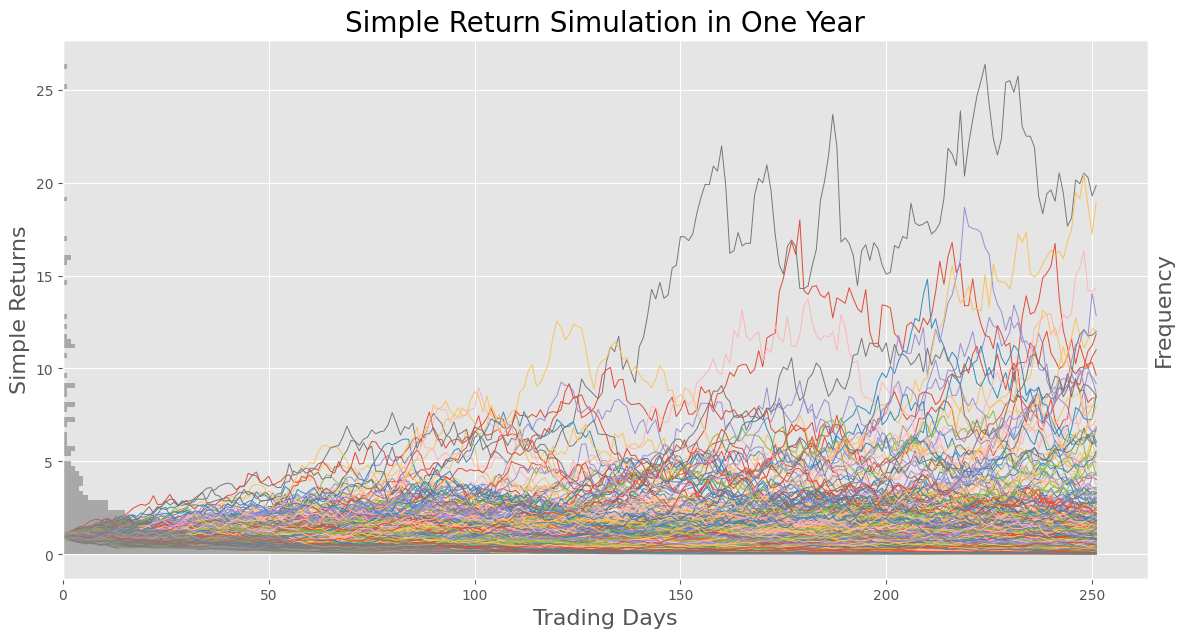

In [7]:
simple_return_simulation(s0=100, r=data_mean, vol=data_std, trading_days=251, paths=500)

A last note: unfavorable feature of simple return is
$$
\left(1+r_1\right)\left(1+r_2\right) \ldots \left(1+r_T\right)-1=\prod_{i=0}^T\left(1+r_i\right)-1
$$
the product of simple return does not follow a normal distribution.

## <font face="gotham" color="purple"> Log Return</font>

Continuous compound has an additive feature on exponential term, we can show
$$
\begin{aligned} S_T & =S_0e^{\frac{r}{T}}e^{\frac{r}{T}} \ldots e^{\frac{r}{T}} \\ & =S_0 e^{\frac{r}{T}+\ldots+\frac{r}{T}} \\ & =S_0 e^r\end{aligned}
$$

Divide $S_0$ on both side and take natural log, we obtain log return at period $T$
$$
\log{\left(\frac{S_T}{S_0}\right)}=\log{e^r} = r_{_T}[T]
$$
The notation is consistent with what we had in time series session, $r_{_T}[T]$ means $T$ periods log return.

What's more, we can decompose gross return into additive log returns
$$
\begin{align}
\log{\left(\frac{S_T}{S_{T-1}}\frac{S_{T-1}}{S_{T-2}}\ldots\frac{S_1}{S_0}\right)} &= \log{\left(\frac{S_T}{S_{T-1}}\right)}
\log{\left(\frac{S_T}{S_{T-1}}\right)}
\ldots\log{\left(\frac{S_T}{S_{T-1}}\right)}\\
r_{_T}[T]&= \underbrace{r_{_{T-1}} + r_{_{T-2}}+\ldots+r_{_0}}_{T \text{ periods}}
\end{align}
$$
This is the additive feature of log return.

Note that $r_{_T}[T]\neq r_{_T}$, the former one is an accumulative return the later is a single period return.

In contrast to simple returns, $r_{_T}[T]$  follows a normal distribution, because it's a linear combination of $T$ normal distributions of $r$.

### <font face="gotham" color="purple"> Simulation of Log Return</font>

Similarly, we add random components on to log return

$$
\ln \left(\frac{S_T}{S_0}\right)=r+\sigma \varepsilon_t, \quad \varepsilon_t \sim N(0,1)
$$

# <font face="gotham" color="purple"> So Which One to Use?</font>

For individual investor without serious quantitative intention, it probably doesn't matter that much which one you use, but for institutions with rigorous quantitative research, this will be among first topics to address before any financial modeling.

The merit of simple return: simple returns are **asset-additive**.

The portfolio return can be added up together
$$
R_p=\sum_{i=1}^k w_i R_i
$$
where $R_p$ is portfolio return, $w_i$ and $R_i$ are weight and simple return of asset $i$.

In contrast, log returns are **time-additive**, i.e.
$$
r_{_T}[T]= r_{_{T-1}} + r_{_{T-2}}+\ldots+r_{_0}
$$

In fact, log returns are not a linear function of asset weights. That is, a portfolio's log return does not equal the weighted average of the log returns of the assets in the portfolio.

The log return of portfolio $r_p$ mathematically will be
$$
r_p=\log \left(\sum_{i=1}^N w_i e^{r_i}\right)
$$
where $w_i$ and $r_i$ are weight and log return of asset $i$. Obviously this is no longer a linear function.

## <font face="gotham" color="purple"> Comparison Experiment</font>

We download two ETFs' (SPY and AGG) historical data and using weight $[0.6, 0.4]$ to calculate the portfolio return.

We calculate the log return of each assets, but using additive method for calculating the portfolio return. Use this return to compare with correct simple portfolio, we expect to see a discrepancy between them.

In [8]:
data = get_data_from_yf(stocks= ["SPY", "AGG"], start_date=dt.date(2020, 1, 1), end_date=dt.datetime.today())

In [9]:
data_simple_return = data.pct_change().dropna()
data_log_return = np.log(data) - np.log(data.shift())

weights = np.array([0.6, 0.4])
simple_portfolio_return = np.sum(data_simple_return.mean() * weights) * TRADING_DAYS
mixed_portfolio_return = np.sum(data_log_return.mean() * weights) * TRADING_DAYS

print("Simple portfolio return: {:.4f}".format(simple_portfolio_return))
print(
    "Simple portfolio return with log asset return: {:.4f}".format(
        mixed_portfolio_return
    )
)

Simple portfolio return: 0.0931
Simple portfolio return with log asset return: 0.0781


So you have to be consistent about when to use which. In general for time series modeling, log return is your choice, when comes to portfolio optimization or management, simple return would be more accurate.

## <font face="gotham" color="purple"> Standardized Return vs Normal Distribution </font>

Standardized returns are valuable for assessing the frequency with which returns fall into rare categories.

For example, AGG has experienced uncommon instances where the return for a single day was 12 standard deviations below the previous closing price.

In [10]:
def standardized_return(simple_return):
    return (simple_return - simple_return.mean()) / np.std(simple_return, axis=0)

In [11]:
n = 300
norm_pdf = sp.stats.norm.pdf(np.linspace(-10, 10, n), loc=0, scale=1)
x_ticks = np.linspace(-10, 10, n)

Compare with standard normal distribution.

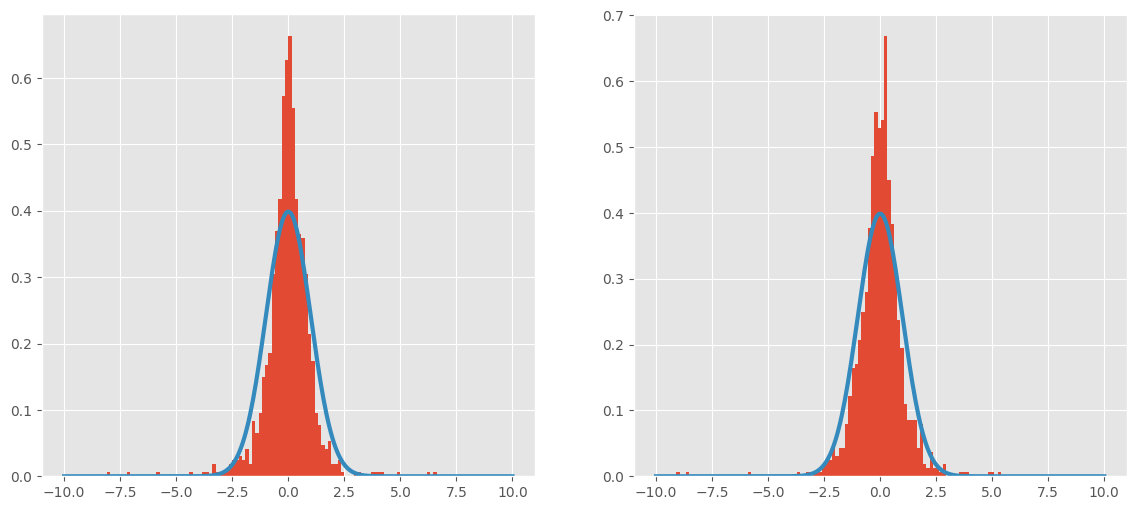

In [12]:
fig, ax = plt.subplots(figsize=(14, 6), nrows=1, ncols=2)
ax[0].hist(
    standardized_return(data_simple_return)["SPY"], bins=100, density=True, label="SPY"
)
ax[1].hist(
    standardized_return(data_simple_return)["AGG"], bins=100, density=True, label="AGG"
)
ax[0].plot(x_ticks, norm_pdf, lw=3, label="Normal")
ax[1].plot(x_ticks, norm_pdf, lw=3, label="Normal")
plt.show()

The return distribution is not Gaussian; however, why do we persist in using the normal distribution in practice? There are several reasons: the normal distribution has a closed-form function, is defined by just two parameters, and the central limit theorem assures its applicability and a finite standard deviation.

Conversely, as demonstrated by the histograms, the fat-tailed distribution may lack a closed-form probability density function (pdf), and most critically, its standard deviation can be infinitely large.

Therefore, insisting on using a fat-tailed model can sometimes make modeling impractical due to the possibility of an infinite standard deviation.

Despite the extremely low probability of fat tails, we still need to have a strategy for handling them.

## <font face="gotham" color="purple"> Assets Return Modeling </font>

We have explored two models previously: one discrete and the other continuous. $$ S_T=S_0\left[1+\frac{r}{T}\right]^{Tt},\qquad\lim _{T \rightarrow \infty} S_T=S_0 e^{rt} $$ These notations are more commonly encountered in time series analysis.

In the realm of financial engineering, however, we typically express these models as follows: $$ S_M = S_0(1+\mu \delta t)^M, \qquad\lim _{\delta t \rightarrow 0} S_M=S_0 e^{\mu M \delta t} = S_0 e^{\mu t} $$ Here, $M=\frac{t}{\delta t}$ represents the number of intervals, and $\mu$ denotes the annual return. For example, when modeling daily data in the United States, we use $\delta t = 252$ which has been defined as a constant at the top of this notebook.

Now suppose you know annualized standard deviation of return $\sigma$, the variance over $M$ periods (can be days, months or years) will be
$$
\sum_{i=1}^{M}\sigma^2 = M \sigma^2 = \frac{t}{\delta t}\sigma^2
$$

If we set $t=1$, i.e. one year period (252 trading days), we obtain variance over $1/\delta t$ periods, because variance is additive
$$
\frac{1}{\delta t}\sigma^2
$$

Naturally, the standard deviation over $1/\delta t$ periods should be the square root of it 
$$
\frac{\sigma}{\sqrt{\delta t}} 
$$

So if you know annualized $\sigma = .30$, what's the standard deviation over a day?
$$
\frac{\sigma}{\sqrt{252}} = \frac{0.30}{\sqrt{252}}
$$

In contrast, the time unit conversion of mean is straightforward, the mean over certain period of time
$$
\mu \ \delta t
$$
where $\mu$ is annualized return, e.g. $\mu=0.08$, daily return is
$$
0.08 \times \frac{1}{252}
$$

Now join what we have discussed together, we can write a model for _asset returns_
$$
R_{t} = \frac{S_{t+1}-S_t}{S_t} =  \mu \delta t+\varepsilon \sigma \sqrt{\delta t}
$$
where $\varepsilon$ is a variable drawn from normal distribution (doesn't have to be standard normal).

Actually this is a famous stochastic process model named _generalized Wiener Process_.

## <font face="gotham" color="purple"> Assets Price Level Modeling </font>

With a slight modification of previous model
$$
S_{i+1}-S_i=\mu S_i \delta t+\varepsilon   S_i \sigma\sqrt{\delta t}\quad\Rightarrow\quad S_{i+1}=(1+\mu \delta t) S_i+\varepsilon  S_i \sigma\sqrt{\delta t}
$$

It provides a more practical usage, that is to simulate asset price in the next period.

In [20]:
data["SPY"].pct_change().mean()

0.0006271963512787584

In [21]:
# use lastest close price
today_price = data["SPY"][-1]
trading_days = 1
paths = 10000

# Generate normal random draws for the simulation
norm_draws = np.random.randn(paths, trading_days)

# Calculate the next day's price for each path
next_day_price = today_price * (1 + data["SPY"].pct_change().mean() + norm_draws *data["SPY"].pct_change().std())

# Insert today's price at the beginning of each simulated path
next_day_price = np.insert(next_day_price, 0, today_price, axis=1)

C:\Users\user\AppData\Local\Temp\ipykernel_22348\2380509826.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  today_price = data["SPY"][-1]


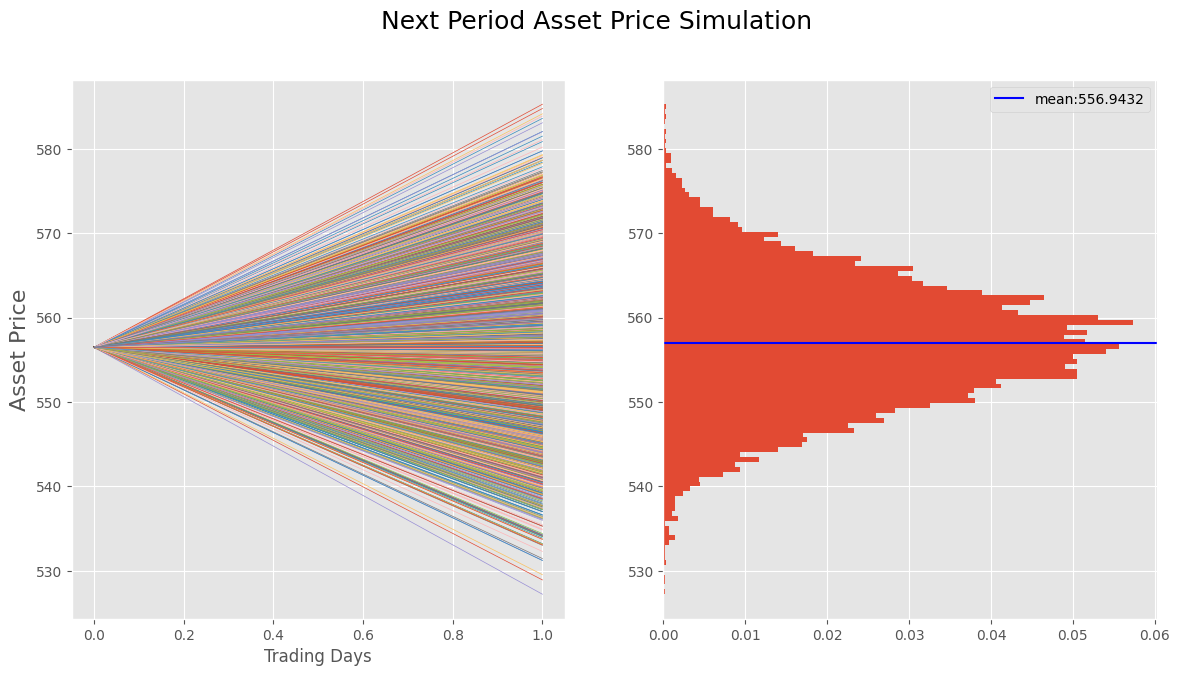

In [22]:
fig, ax = plt.subplots(figsize=(14, 7), nrows=1, ncols=2)

for j in next_day_price:
    ax[0].plot([i for i in range(0, trading_days + 1)], j, linewidth=0.5)

ax[0].set_ylabel("Asset Price", fontsize=16)
ax[0].set_xlabel("Trading Days")

next_price_list = []
for i in next_day_price:
    next_price_list.append(i[1])

ax[1].hist(next_price_list, bins=100, orientation="horizontal", density=True)
ax[1].axhline(
    np.mean(next_price_list),
    color="blue",
    label="mean:{:.4f}".format(np.mean(next_price_list)),
)
ax[1].legend()
plt.suptitle("Next Period Asset Price Simulation", size=18)
plt.show()

## <font face="gotham" color="purple"> Insights </font>

Take a close look at the model
$$
S_{i+1}-S_i=\mu S_i \delta t+\varepsilon   S_i \sigma\sqrt{\delta t},\\
\text{ or}\\
S_{i+1}=(1+\mu \delta t)S_i+\varepsilon   S_i \sigma\sqrt{\delta t}
$$
This is exactly what I was doing in codes above ```[1 + r / trading_days + vol / (np.sqrt(trading_days))]```! The only difference is that we were simulating cumulative returns rather than price.

On the left-hand side, $\delta t$ appears twice, i.e. $\delta t$ and $\sqrt{\delta t}$. 

From the plot, we understand that for $0<\delta t < 1$, it follows that $\delta t<\sqrt{\delta t}$. As $\delta t$ approaches $0$, the term $\varepsilon S_i \sigma\sqrt{\delta t}$ becomes increasingly dominant. This indicates that our model focuses primarily on volatility over extremely short time periods.

In simpler terms, this means that in the short term, random fluctuations significantly outweigh the overall growth (or drift), as you can see from the plot below, the slop of the square root curve infinitely converges to $1$ as the interval converges to $0$.

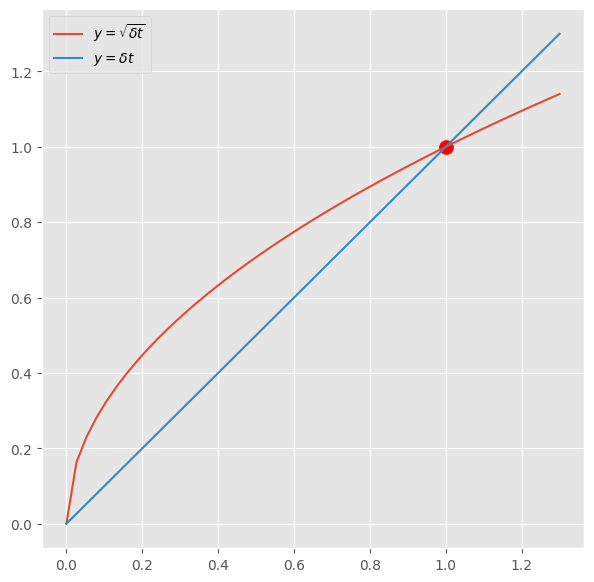

In [26]:
x = np.linspace(0, 1.3)
y = np.sqrt(x)
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(x, y, label=r"$y = \sqrt{\delta t}$")
ax.plot(x, x, label=r"$y = \delta t$")
ax.scatter(1, 1, color="red", s=100)
ax.legend()
plt.show()

For the sake of mathematical convenience, many people will be using _continuous version_ of this model, i.e.
$$
d S=\mu S d t+\sigma S d X
$$
where $E[d X]=0$ and $E\left[d X^2\right]=d t$. A full derivation will be carefully discussed in later chapters, because this is the foundation of all other quantitative financial models.